# Image color quantization using clustering

## Introduction

This demonstration will look at color quantization for a sample image using a clustering technique based on maximum independent set.  The idea is to reduce the number of distinct colors in the image, while maintaining visual similarity to the original.

This will be accomplished by finding a subset of representative colors within the image (i.e., a new color palette), such that the representative colors are all separated from each other by some minimum distance.  Then the original colors are approximated by the nearest representative color.

The demonstration will include the following steps:
- Load a sample image
- Reduce the size of the sample image (downsample) to make the demonstration data easier to work with
- Construct and solve a binary quadratic model to represent the maximum independent set problem
- Visualize the original and reduced colors within the color space
- Compare the original and reduced images

## Prepare the image data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree as KDTree
from scipy.spatial import Voronoi, voronoi_plot_2d

import dimod
from dwave.system import LeapHybridBQMSampler

First we load a test image [1] that has had the blue channel removed.

Data shape: (196, 200, 3)
Number of pixels: 39200


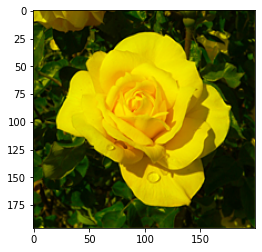

In [4]:
img_orig = plt.imread('Rosa_Gold_Glow_2_small_noblue.png')
print('Data shape:', img_orig.shape)
print('Number of pixels:', np.prod(img_orig.shape[:2]))
plt.imshow(img_orig);

To reduce the size of the dataset, we will first downsample the image:

New number of pixels: 2450


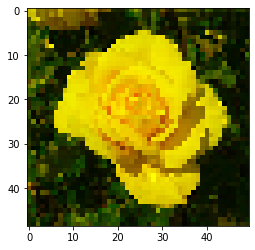

In [5]:
DOWNSAMPLE = 4
img = img_orig[::DOWNSAMPLE, ::DOWNSAMPLE, :]
print('New number of pixels:', np.prod(img.shape[:2]))
plt.imshow(img);

Let's inspect the data.  The format is a 3D array, where the last dimension is an array of RGB values.  Here we print the color values for the 10 pixels in the first 5 rows and first 2 columns:

In [6]:
print(img[:5, :2, :])

[[[0.78431374 0.73333335 0.        ]
  [0.83137256 0.7921569  0.        ]]

 [[0.75686276 0.7019608  0.        ]
  [0.7764706  0.7372549  0.        ]]

 [[0.30980393 0.3137255  0.        ]
  [0.83137256 0.7764706  0.        ]]

 [[0.25882354 0.32156864 0.        ]
  [0.14509805 0.25882354 0.        ]]

 [[0.14509805 0.2627451  0.        ]
  [0.07450981 0.1764706  0.        ]]]


## Inspect the original colors

For our analysis, we will reshape the data into a 2D array.  Here we check the number of datapoints and the number of unique colors:

In [7]:
nrow, ncol, _ = img.shape
img_flat = img.reshape((nrow * ncol, 3))
print('Number of pixels:', len(img_flat))
print('Number of colors:', len(np.unique(img_flat, axis=0)))

Number of pixels: 2450
Number of colors: 1877


To inspect the original colors, we use a scatterplot of the red and green values in the image data:

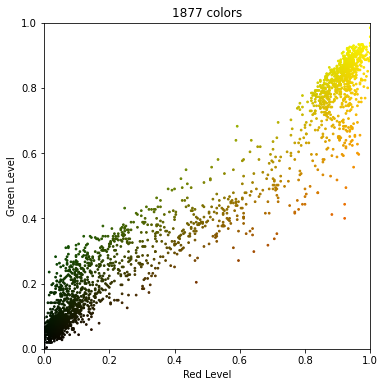

In [8]:
def plot_colorspace(img, ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=1.5*plt.figaspect(1))

    ax.scatter(img[:, 0], img[:, 1], c=img, marker='.', s=12)
    ax.set_xlabel('Red Level')
    ax.set_ylabel('Green Level')
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'{len(np.unique(img, axis=0))} colors')
    return ax

plot_colorspace(img_flat);

## Maximum independent set problem

To reduce the color space, we will solve a maximum independent set problem.  The idea is to find a set of *representative points*, such that no two representative points are within a given distance of each other, which is referred to as $\varepsilon$.  The goal will be to find as many such representative points as possible, subject to this mutual separation criterion.  This is known as a maximum independent set problem.

We start by defining a binary variable for each data point, $s_i$.  Each binary variable denotes whether or not the given data point is selected as a representative point.  Since we want to choose as many representative points as possible, the objective function is simply:

\begin{equation}
\max \sum_i s_i
\end{equation}

For the D-Wave solvers, we express the objective as a minimization:

\begin{equation}
\min -\sum_i s_i
\end{equation}

To make sure no two representative points are in the same neighborhood, we want to ensure that the following condition is met:

\begin{equation}
\sum_{i<j} s_i s_j N_{ij}^{(\varepsilon)} = 0
\end{equation}

where $N_{ij}^{(\varepsilon)}=1$ if points $i$ and $j$ are within a distance of $\varepsilon$, $N_{ij}^{(\varepsilon)}=0$ otherwise.

We can include the constraint as part of the objective through a penalty function:

\begin{equation}
\min -\sum_i s_i + \lambda \sum_{i<j} s_i s_j N_{ij}^{(\varepsilon)}
\end{equation}

Here, $\lambda$ is a parameter that controls the strength of the penalty.  It is easy to show that as long as $\lambda > 1$, the solution will satisfy the neighborhood constraint.  To see this, notice that choosing to add a single point that violates the neighborhood constraint improves (decreases) the solution by 1, whereas the corresponding penalty for a single violation is $\lambda$.  Thus, we only need to make sure that the smallest possible penalty outweighs the benefit, or $\lambda > 1$.

### Distance function

First we begin by defining a function to calculate distance between two points in the color space.  This demonstration will use Euclidean distance:

In [9]:
def distance(x, y):
    return np.sqrt(sum((x-y)**2))

For example, here is the distance between red (`[1, 0, 0]`) and green (`[0, 1, 0]`):

In [10]:
red = np.array([1, 0, 0])
green = np.array([0, 1, 0])
print('Distance:', distance(red, green))

Distance: 1.4142135623730951


The following shows a circle of radius $\varepsilon=0.15$ centered on the first point.  Any point within this circle is within the neighborhood of this point.

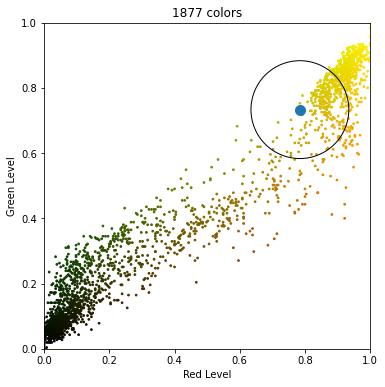

In [11]:
ax = plot_colorspace(img_flat)
idx = 0
ax.plot([img_flat[idx, 0]], [img_flat[idx, 1]], 'o', ms=10)
c = plt.Circle(img_flat[idx, :2], 0.15, fill=False)
ax.add_artist(c);

### Construct BQM

Recall that the objective function involves minimizing the number of representative points.  Thus, the linear term for each binary variable in our model is simply $-1$.  We begin by creating a Binary Quadratic Model (BQM) instance and defining the linear term for each variable:

In [12]:
n = len(img_flat)
bqm = dimod.BinaryQuadraticModel('BINARY')
bqm.add_linear_from_array(np.repeat(-1, n))

For the interaction terms in the model, we need to check whether each pair of points is within a neighborhood given by $\varepsilon$: if the points are within this neighborhood, we apply a penalty coefficient of $\lambda$.  We need $\lambda > 1$ to ensure that the solution satisifes the neighborhood constraints, so we choose $\lambda = 1.1$.  For this example, we will use a neighborhood radius of $\varepsilon = 0.15$.

In [21]:
lam = 1.1
eps = 0.15
# Note: this is for demonstration.  The distance calculation and BQM
# construction can be done much more efficiently using
# scipy.spatial.distance.pdist.
for i in range(n):
    for j in range(i+1, n):
        d = distance(img_flat[i,:], img_flat[j,:])
        if d < eps:
            bqm.add_quadratic(i, j, lam)

### Solve BQM

To solve the optimization problem, we will use the Leap Hybrid BQM sampler.  We take the best solution that it finds and extract the indices of the representative points:

In [14]:
sampler = LeapHybridBQMSampler()
results = sampler.sample(bqm)
best_solution = list(results.first.sample.values())
solution_indices = np.where(best_solution)[0]

Check the quality of the solution:

In [15]:
num_selected = len(solution_indices)
print(f'Found {len(solution_indices)} points')
print('Energy:', results.first.energy)
feasible = -results.first.energy == num_selected
print('Feasible:', feasible)
print(solution_indices)

Found 21 points
Energy: -21.0
Feasible: True
[  14   78  296  375  845  877  974 1022 1042 1187 1428 1571 1572 1837
 1878 2087 2217 2279 2307 2361 2415]


## Inspect the reduced set of colors

We now have the indices of the representative points.  We create a plot showing the locations of the representative points within the colorspace.  The plot can be updated to show (by uncommenting the indicated line) the boundaries that define how the original data would be mapped to the nearest representative point; these boundaries form a Voronoi diagram.

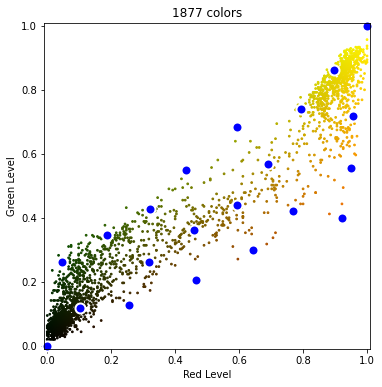

In [27]:
ax = plot_colorspace(img_flat)
ax.plot(img_flat[solution_indices, 0], img_flat[solution_indices, 1], 'o', 
        mfc='blue', mec='white', mew=2, ms=10, clip_on=False)
vor = Voronoi(img_flat[solution_indices, :2])
# Uncomment to show Voronoi diagram:
#voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False)
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)

for idx in solution_indices:
    c = plt.Circle(img_flat[idx, :2], eps, fill=False, color='blue', alpha=0.2)
    # Uncomment to show neighborhood radius of each representative point:
    #ax.add_artist(c)

To reduce the original set of colors, we want to assign the original colors to the nearest representative point.  This can be done efficiently using a KD tree:

In [17]:
def get_reduced_image(img, representative_points):
    tree = KDTree(img[representative_points, :])
    dist, idx_closest = tree.query(img, distance_upper_bound=np.inf)
    return img[representative_points[idx_closest], :]

new_img_flat = get_reduced_image(img_flat, solution_indices)

Finally, we compare the image with the original color space against the new image in the reduced color space:

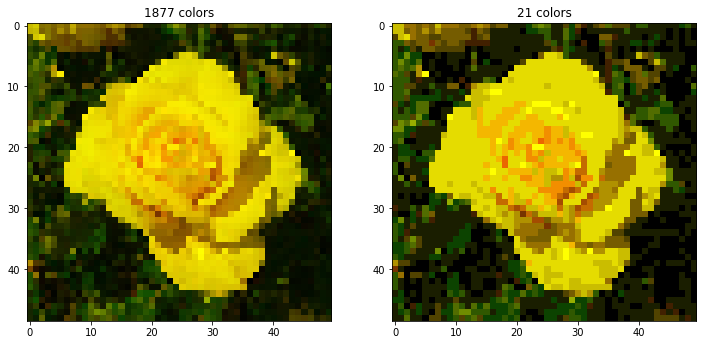

In [18]:
f, axes = plt.subplots(1, 2, figsize=1.5*plt.figaspect(0.5))
axes[0].imshow(img)
axes[1].imshow(new_img_flat.reshape(img.shape))
axes[0].set_title(f'{len(np.unique(img_flat, axis=0))} colors')
axes[1].set_title(f'{len(np.unique(new_img_flat, axis=0))} colors');

## References

[1] https://commons.wikimedia.org/wiki/File:Rosa_Gold_Glow_2_small_noblue.png

[2] Jaschek, Tim, Marko Bucyk, and Jaspreet S. Oberoi. 2019. “A Quantum Annealing-Based Approach to Extreme Clustering.” https://arxiv.org/abs/1903.08256.